## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import sys
import tensorflow as tf
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

sys.path.append('../../src')
from rnn.rnn_from_scratch import SimpleRNNModel
from utils.data_preprocessing import TextPreprocessor
from rnn.model_training import create_keras_rnn

import warnings
warnings.filterwarnings("ignore")


In [2]:
train = pd.read_csv('../../datasets/train.csv', index_col='id')
valid = pd.read_csv('../../datasets/valid.csv', index_col='id')
test = pd.read_csv('../../datasets/test.csv', index_col='id')
train.head()

,text,label
id,,
219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
209,Kue-kue yang disajikan bikin saya bernostalgia...,positive
436,Ibu pernah bekerja di grab indonesia,neutral
394,Paling suka banget makan siang di sini ayam sa...,positive
592,Pelayanan bus DAMRI sangat baik,positive


In [13]:
test.head()

,text,label
id,,
411,"Dekat dengan hotel saya menginap, hanya ditemp...",positive
729,"Iya benar, dia sedang jaga warung.",neutral
373,Kangkungnya lumayan tapi kepiting saus padangn...,negative
262,Bertempat di braga city walk yang satu gedung ...,positive
177,Gianyar terima bantuan sosial 2018 sebesar rp ...,neutral


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 219 to 719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    500 non-null    object
 1   label   500 non-null    object
dtypes: object(2)
memory usage: 11.7+ KB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 411 to 768
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    400 non-null    object
 1   label   400 non-null    object
dtypes: object(2)
memory usage: 9.4+ KB


## Preprocessing

In [3]:
preprocessor = TextPreprocessor(vocab_size=10000, max_length=100)
processed_data = preprocessor.preprocess_dataset(train, valid, test, use_vectorizer=False)

train_seq = processed_data['train_sequences']
val_seq = processed_data['val_sequences']
test_seq = processed_data['test_sequences']
train_labels = processed_data['train_labels']
val_labels = processed_data['val_labels']
test_labels = processed_data['test_labels']

vocab_size = processed_data['vocab_size']
num_classes = processed_data['num_classes']

print(f"Vocab size: {vocab_size}")
print(f"Num classes: {num_classes}")
print(f"Sequence shape: {train_seq.shape}")
print(f"Labels distribution: {np.bincount(train_labels)}")

Vocab size: 2796
Num classes: 3
Sequence shape: (500, 100)
Labels distribution: [192 119 189]


## Modelling

In [4]:
configs = {
    # Pengaruh jumlah layer (3 variasi)
    'rnn_1layer': {'hidden_sizes': [64], 'bidirectional': False},
    'rnn_2layer': {'hidden_sizes': [64, 32], 'bidirectional': False},
    'rnn_3layer': {'hidden_sizes': [64, 32, 16], 'bidirectional': False},
    
    # Pengaruh banyak cell (3 variasi)
    'rnn_cells_32': {'hidden_sizes': [32, 32], 'bidirectional': False},
    'rnn_cells_64': {'hidden_sizes': [64, 64], 'bidirectional': False},
    'rnn_cells_128': {'hidden_sizes': [128, 128], 'bidirectional': False},
    
    # Pengaruh arah (2 variasi)
    'rnn_unidirectional': {'hidden_sizes': [64, 32], 'bidirectional': False},
    'rnn_bidirectional': {'hidden_sizes': [64, 32], 'bidirectional': True}
}

In [5]:
def plot_training_history(training_results):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Layer variations
    layer_configs = ['rnn_1layer', 'rnn_2layer', 'rnn_3layer']
    for i, config in enumerate(layer_configs):
        if config in training_results:
            history = training_results[config]['history']
            
            # Loss plot
            axes[0, 0].plot(history['loss'], label=f'{config} - Train')
            axes[0, 0].plot(history['val_loss'], label=f'{config} - Val')
            axes[0, 0].set_title('Effect of Number of Layers - Loss')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].legend()
            
            # Accuracy plot
            axes[1, 0].plot(history['accuracy'], label=f'{config} - Train')
            axes[1, 0].plot(history['val_accuracy'], label=f'{config} - Val')
            axes[1, 0].set_title('Effect of Number of Layers - Accuracy')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Accuracy')
            axes[1, 0].legend()
    
    # Cell variations
    cell_configs = ['rnn_cells_32', 'rnn_cells_64', 'rnn_cells_128']
    for i, config in enumerate(cell_configs):
        if config in training_results:
            history = training_results[config]['history']
            
            # Loss plot
            axes[0, 1].plot(history['loss'], label=f'{config} - Train')
            axes[0, 1].plot(history['val_loss'], label=f'{config} - Val')
            axes[0, 1].set_title('Effect of Cell Count - Loss')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].legend()
            
            # Accuracy plot
            axes[1, 1].plot(history['accuracy'], label=f'{config} - Train')
            axes[1, 1].plot(history['val_accuracy'], label=f'{config} - Val')
            axes[1, 1].set_title('Effect of Cell Count - Accuracy')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Accuracy')
            axes[1, 1].legend()
    
    # Direction variations
    direction_configs = ['rnn_unidirectional', 'rnn_bidirectional']
    for i, config in enumerate(direction_configs):
        if config in training_results:
            history = training_results[config]['history']
            
            # Loss plot
            axes[0, 2].plot(history['loss'], label=f'{config} - Train')
            axes[0, 2].plot(history['val_loss'], label=f'{config} - Val')
            axes[0, 2].set_title('Effect of Direction - Loss')
            axes[0, 2].set_xlabel('Epoch')
            axes[0, 2].set_ylabel('Loss')
            axes[0, 2].legend()
            
            # Accuracy plot
            axes[1, 2].plot(history['accuracy'], label=f'{config} - Train')
            axes[1, 2].plot(history['val_accuracy'], label=f'{config} - Val')
            axes[1, 2].set_title('Effect of Direction - Accuracy')
            axes[1, 2].set_xlabel('Epoch')
            axes[1, 2].set_ylabel('Accuracy')
            axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()


Training rnn_1layer...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.3540 - loss: 1.1154 - val_accuracy: 0.3700 - val_loss: 1.1175
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4577 - loss: 1.0284 - val_accuracy: 0.4400 - val_loss: 1.0946
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6157 - loss: 0.8331 - val_accuracy: 0.4000 - val_loss: 1.1892
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7102 - loss: 0.7163 - val_accuracy: 0.3200 - val_loss: 1.3893
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7730 - loss: 0.5656 - val_accuracy: 0.3400 - val_loss: 1.5419
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9017 - loss: 0.3729 - val_accuracy: 0.3400 - val_loss: 1.6968
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9612 - loss: 0.2183 - val_accuracy: 0.3700 - val_loss: 1.9579
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9450 - loss: 0.2234 - 

✅ rnn_1layer - F1: 0.4006

Training rnn_2layer...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.3562 - loss: 1.1302 - val_accuracy: 0.3800 - val_loss: 1.0837
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4188 - loss: 1.0749 - val_accuracy: 0.4000 - val_loss: 1.0643
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5997 - loss: 0.9093 - val_accuracy: 0.4500 - val_loss: 1.1914
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7847 - loss: 0.5852 - val_accuracy: 0.4300 - val_loss: 1.1355
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9519 - loss: 0.2617 - val_accuracy: 0.4300 - val_loss: 1.3467
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.1287 - val_accuracy: 0.4100 - val_loss: 1.5795
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9995 - loss: 0.0644 - val_accuracy: 0.4100 - val_loss: 1.6587
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy

✅ rnn_2layer - F1: 0.3958

Training rnn_3layer...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.3275 - loss: 1.2510 - val_accuracy: 0.3900 - val_loss: 1.0846
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3683 - loss: 1.1756 - val_accuracy: 0.3600 - val_loss: 1.1772
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4444 - loss: 1.0684 - val_accuracy: 0.3600 - val_loss: 1.2195
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5539 - loss: 0.9351 - val_accuracy: 0.4300 - val_loss: 1.1383
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6427 - loss: 0.8519 - val_accuracy: 0.4000 - val_loss: 1.2517
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8079 - loss: 0.5575 - val_accuracy: 0.4400 - val_loss: 1.2557
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9114 - loss: 0.3665 - val_accuracy: 0.3900 - val_loss: 1.4027
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accurac

✅ rnn_3layer - F1: 0.3682

Training rnn_cells_32...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.3348 - loss: 1.1921 - val_accuracy: 0.3600 - val_loss: 1.0791
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4739 - loss: 1.0184 - val_accuracy: 0.3500 - val_loss: 1.1720
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7666 - loss: 0.6936 - val_accuracy: 0.3200 - val_loss: 1.3626
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9288 - loss: 0.3447 - val_accuracy: 0.3500 - val_loss: 1.4467
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9895 - loss: 0.1305 - val_accuracy: 0.3600 - val_loss: 1.7003
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9979 - loss: 0.0580 - val_accuracy: 0.3700 - val_loss: 1.6701
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 1.0000 - loss: 0.0289 - val_accuracy: 0.3500 - val_loss: 1.7378
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accura

✅ rnn_cells_32 - F1: 0.4298

Training rnn_cells_64...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.3424 - loss: 1.1869 - val_accuracy: 0.3800 - val_loss: 1.1162
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4364 - loss: 1.0156 - val_accuracy: 0.4100 - val_loss: 1.2782
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7821 - loss: 0.6012 - val_accuracy: 0.3600 - val_loss: 1.3535
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9428 - loss: 0.2720 - val_accuracy: 0.3000 - val_loss: 1.8297
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9798 - loss: 0.1393 - val_accuracy: 0.4000 - val_loss: 1.9742
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9922 - loss: 0.0581 - val_accuracy: 0.3300 - val_loss: 1.8079
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9896 - loss: 0.0492 - val_accuracy: 0.4500 - val_loss: 1.8940
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accu

✅ rnn_cells_64 - F1: 0.3833

Training rnn_cells_128...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.3554 - loss: 1.2013 - val_accuracy: 0.3800 - val_loss: 1.1091
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.3727 - loss: 1.1150 - val_accuracy: 0.4500 - val_loss: 1.0888
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3677 - loss: 1.1963 - val_accuracy: 0.3200 - val_loss: 1.1316
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3764 - loss: 1.1193 - val_accuracy: 0.4000 - val_loss: 1.0882
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3609 - loss: 1.1666 - val_accuracy: 0.3200 - val_loss: 1.1219
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.3661 - loss: 1.1920 - val_accuracy: 0.3700 - val_loss: 1.0941
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.3965 - loss: 1.1911 - val_accuracy: 0.3700 - val_loss: 1.1149
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - acc

✅ rnn_cells_128 - F1: 0.1844

Training rnn_unidirectional...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.3477 - loss: 1.1516 - val_accuracy: 0.4600 - val_loss: 1.0412
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4709 - loss: 0.9844 - val_accuracy: 0.4900 - val_loss: 1.0046
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5986 - loss: 0.8464 - val_accuracy: 0.4800 - val_loss: 1.1153
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6501 - loss: 0.7294 - val_accuracy: 0.5300 - val_loss: 1.1769
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8082 - loss: 0.4761 - val_accuracy: 0.6500 - val_loss: 1.0252
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9584 - loss: 0.2329 - val_accuracy: 0.5900 - val_loss: 1.2493
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9953 - loss: 0.1156 - val_accuracy: 0.5900 - val_loss: 1.4252
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

✅ rnn_unidirectional - F1: 0.5805

Training rnn_bidirectional...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.4201 - loss: 1.0923 - val_accuracy: 0.4900 - val_loss: 1.0140
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6870 - loss: 0.7740 - val_accuracy: 0.5200 - val_loss: 0.9661
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8860 - loss: 0.4020 - val_accuracy: 0.5100 - val_loss: 1.1165
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9599 - loss: 0.1600 - val_accuracy: 0.5100 - val_loss: 1.1512
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9939 - loss: 0.0628 - val_accuracy: 0.4800 - val_loss: 1.3016
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 1.0000 - loss: 0.0234 - val_accuracy: 0.4900 - val_loss: 1.3820
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 1.0000 - loss: 0.0177 - val_accuracy: 0.4600 - val_loss: 1.3966
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms

✅ rnn_bidirectional - F1: 0.4295


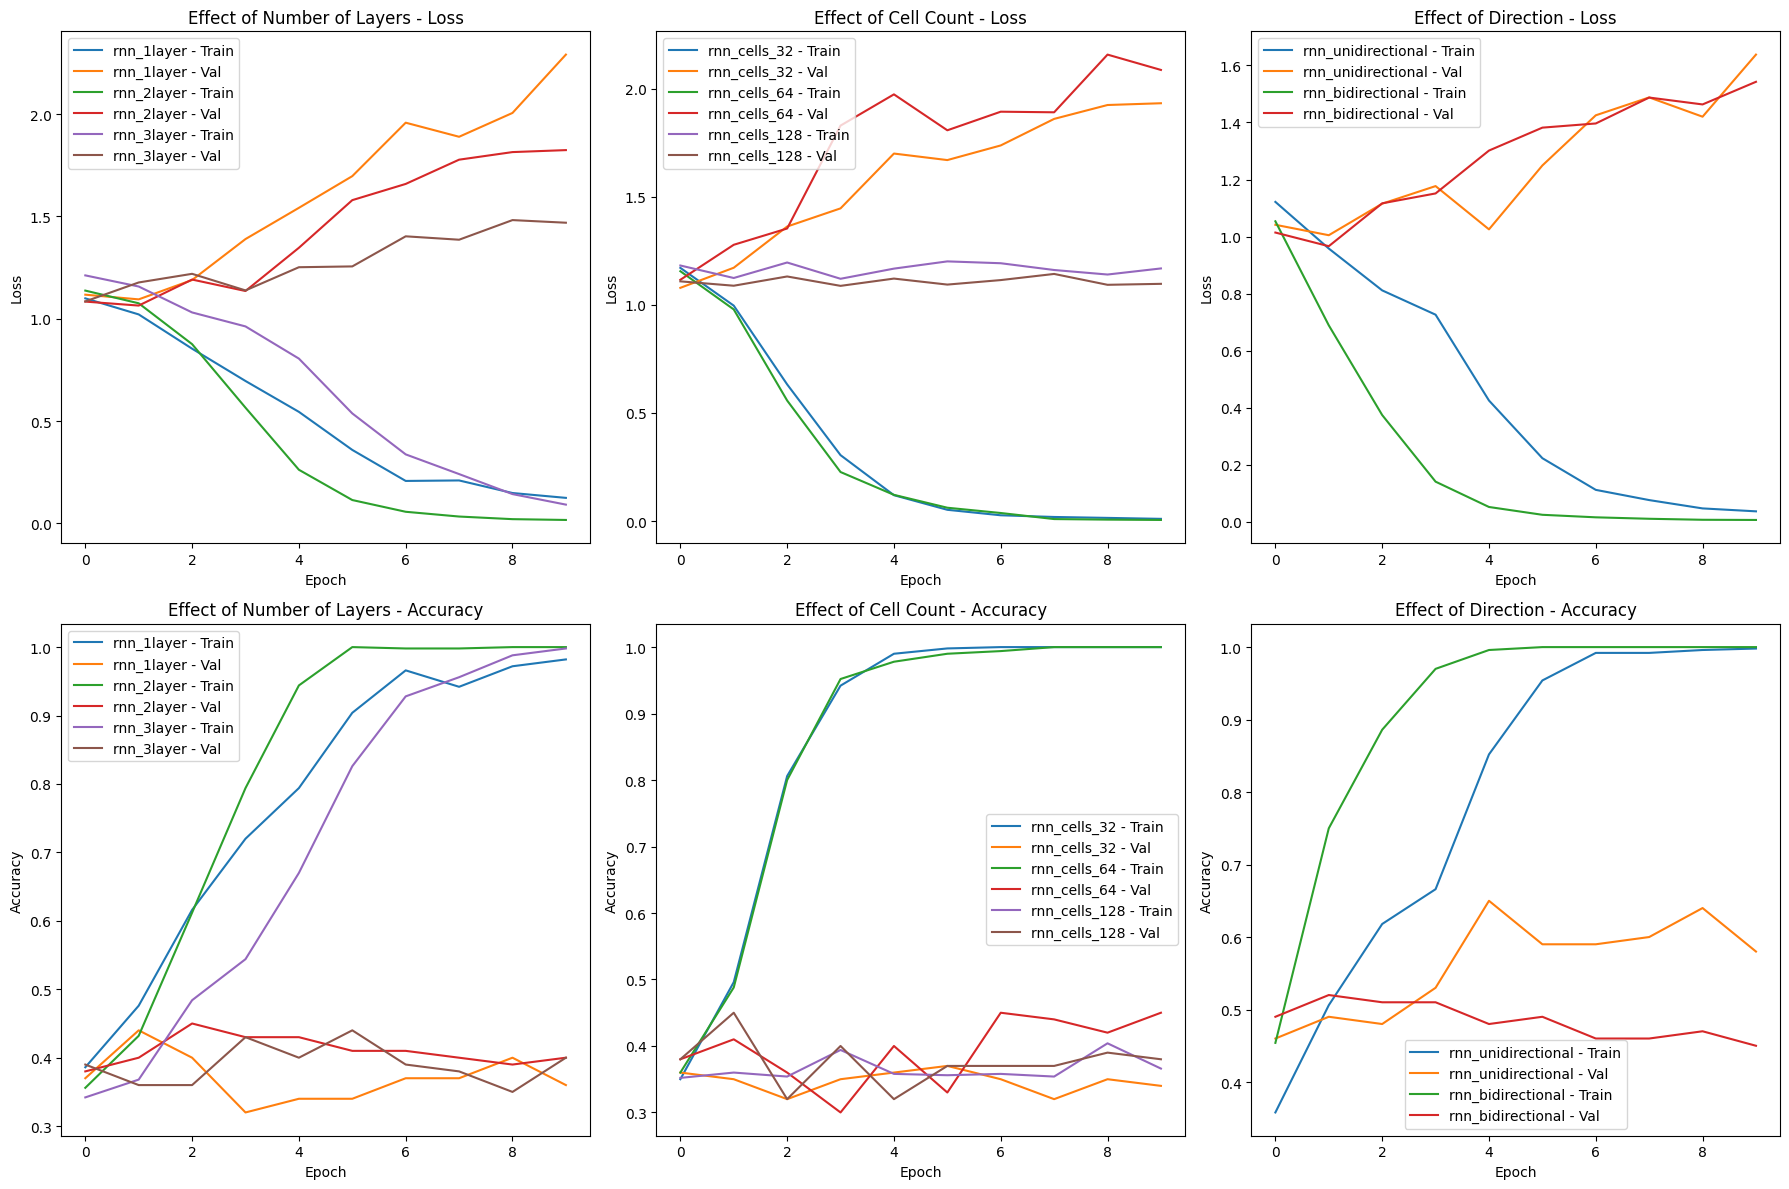

In [6]:
training_results = {}

for name, config in configs.items():
    print(f"\nTraining {name}...")
    
    # Create and train
    model = create_keras_rnn(vocab_size, num_classes, config)
    
    history = model.fit(
        train_seq, train_labels,
        validation_data=(val_seq, val_labels),
        epochs=10, batch_size=32, verbose=1
    )
    
    # Evaluate
    y_pred = np.argmax(model.predict(test_seq), axis=1)
    macro_f1 = f1_score(test_labels, y_pred, average='macro')
    
    # Save
    model.save(f'../../models/{name}.h5')
    
    training_results[name] = {
        'config': config,
        'macro_f1': macro_f1,
        'history': history.history
    }
    
    print(f"✅ {name} - F1: {macro_f1:.4f}")
    
plot_training_history(training_results)

## Compare models

In [7]:
def compare_implementations(model_path, config, test_data):
    """Compare Keras vs from scratch"""
    test_X, test_y = test_data
    
    # Load Keras model
    keras_model = tf.keras.models.load_model(model_path)
    
    # Create scratch model
    scratch_model = SimpleRNNModel(
        vocab_size=vocab_size,
        embedding_dim=128,
        hidden_sizes=config['hidden_sizes'],
        num_classes=num_classes,
        bidirectional=config['bidirectional']
    )
    
    # Load weights to scratch model
    scratch_model.load_keras_weights(model_path)
    
    # Get predictions
    keras_proba = keras_model.predict(test_X, verbose=0)
    scratch_proba = scratch_model.predict_proba(test_X)
    
    keras_pred = np.argmax(keras_proba, axis=1)
    scratch_pred = scratch_model.predict(test_X)
    
    # Calculate metrics
    keras_f1 = f1_score(test_y, keras_pred, average='macro')
    scratch_f1 = f1_score(test_y, scratch_pred, average='macro')
    
    max_diff = np.max(np.abs(keras_proba - scratch_proba))
    agreement = np.mean(keras_pred == scratch_pred)
    
    
    return {
        'keras_f1': keras_f1,
        'scratch_f1': scratch_f1,
        'max_diff': max_diff,
        'agreement': agreement
    }

In [8]:
test_data = (test_seq, test_labels)
comparison_results = {}

for name, config in configs.items():
    print(f"\nComparing {name}...")
    model_path = f'../../models/{name}.h5'
    
    result = compare_implementations(model_path, config, test_data)
    comparison_results[name] = result
    
    print(f"  Keras F1: {result['keras_f1']:.4f}")
    print(f"  Scratch F1: {result['scratch_f1']:.4f}")
    print(f"  Max diff: {result['max_diff']:.6f}")
    print(f"  Agreement: {result['agreement']:.4f}")


Comparing rnn_1layer...


Weights loaded from ../../models/rnn_1layer.h5


  Keras F1: 0.4006
  Scratch F1: 0.4006
  Max diff: 0.000005
  Agreement: 1.0000

Comparing rnn_2layer...
Weights loaded from ../../models/rnn_2layer.h5


  Keras F1: 0.3958
  Scratch F1: 0.3958
  Max diff: 0.000002
  Agreement: 1.0000

Comparing rnn_3layer...


Weights loaded from ../../models/rnn_3layer.h5


  Keras F1: 0.3682
  Scratch F1: 0.3682
  Max diff: 0.000003
  Agreement: 1.0000

Comparing rnn_cells_32...
Weights loaded from ../../models/rnn_cells_32.h5


  Keras F1: 0.4298
  Scratch F1: 0.4298
  Max diff: 0.000002
  Agreement: 1.0000

Comparing rnn_cells_64...
Weights loaded from ../../models/rnn_cells_64.h5


  Keras F1: 0.3833
  Scratch F1: 0.3833
  Max diff: 0.000002
  Agreement: 1.0000

Comparing rnn_cells_128...
Weights loaded from ../../models/rnn_cells_128.h5


  Keras F1: 0.1844
  Scratch F1: 0.1844
  Max diff: 0.000000
  Agreement: 1.0000

Comparing rnn_unidirectional...
Weights loaded from ../../models/rnn_unidirectional.h5


  Keras F1: 0.5805
  Scratch F1: 0.5805
  Max diff: 0.000012
  Agreement: 1.0000

Comparing rnn_bidirectional...


Weights loaded from ../../models/rnn_bidirectional.h5
  Keras F1: 0.4295
  Scratch F1: 0.4295
  Max diff: 0.000003
  Agreement: 1.0000
